# Dropout
Dropout [1] est une technique de régularisation qui consiste à forcer aléatoirement à zéro certains neurones lors de la propagation avant. Pour cet exercice, vous serez appelé à coder une couche de dropout et de l'incorporer à votre réseau pleinement connecté.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [33]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from ift725.classifiers.fc_net import *
from ift725.data_utils import get_CIFAR10_data
from ift725.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from ift725.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout: propagation avant
Dans le fichier `ift725/layers.py`, codez la propagation avant du dropout. Puisque dropout se comporte différemment en entraînement qu'en test, assurez-vous que les deux modes fonctionnent bien.

Exécutez la cellule que voici et assurez-vous que la moyenne de out_train soit la même que out_test.

NOTE : vous devez implémenter du "inverse dropout".  Pour plus de détail, voir https://deepnotes.io/dropout

In [35]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out_train, _ = forward_inverted_dropout(x, {'mode': 'train', 'p': p})
  out_test, _ = forward_inverted_dropout(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out_train.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out_train == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.3
Mean of input:  10.000674699958465
Mean of train-time output:  9.996906836954857
Mean of test-time output:  10.000674699958465
Fraction of train-time output set to zero:  0.30028
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.000674699958465
Mean of train-time output:  9.971365813593712
Mean of test-time output:  10.000674699958465
Fraction of train-time output set to zero:  0.601008
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  10.000674699958465
Mean of train-time output:  9.986512808630932
Mean of test-time output:  10.000674699958465
Fraction of train-time output set to zero:  0.75034
Fraction of test-time output set to zero:  0.0



# Dropout: rétro-propagation
Dans le fichier `ift725/layers.py`, codez la rétro-propagation du dropout. Vous pourrez par la suite tester votre code avec la cellule que voici.

In [36]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = forward_inverted_dropout(x, dropout_param)
dx = backward_inverted_dropout(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: forward_inverted_dropout(xx, dropout_param)[0], x, dout)

# Error should be below 1e-10
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.892904044011933e-11


# Réseau multi-couches avec Dropout
Dans le fichier `ift725/classifiers/fc_net.py`, modifiez votre code afin d'y incorporer dropout. Plus particulièrement, si le constructeur du réseau reçoit une valeur non nulle pour le paramètre `dropout`, le réseau devrait ajouter du dropout après chaque ReLU. Vous pouvez tester votre code avec la cellule que voici.

In [37]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNeuralNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

    
  # Error should be below 1e-5
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  0
Initial loss:  3.407349099847944
W1 relative error: 1.17e-06
W2 relative error: 3.14e-07
b1 relative error: 9.30e-09
b2 relative error: 7.98e-10

Running check with dropout =  0.25
Initial loss:  3.4340425205761362
W1 relative error: 5.30e-07
W2 relative error: 6.75e-08
b1 relative error: 6.79e-09
b2 relative error: 2.04e-02

Running check with dropout =  0.5
Initial loss:  3.373132237135437
W1 relative error: 1.28e-09
W2 relative error: 1.29e-08
b1 relative error: 3.00e-10
b2 relative error: 6.03e-10



# Expérimentation
Ici nous entrainerons 2 réseaux de neurones avec 500 données: l'un utilisera du dropout et l'autre non. Nous pourrons alors visualiser les justesses obtenues en entraînement et en validation.

In [38]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
  model = FullyConnectedNeuralNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

0
(Iteration 1 / 125) loss: inf
(Epoch 0 / 25) train acc: 0.018000; val_acc: 0.012000
(Epoch 1 / 25) train acc: 0.178000; val_acc: 0.129000
(Epoch 2 / 25) train acc: 0.274000; val_acc: 0.182000
(Epoch 3 / 25) train acc: 0.358000; val_acc: 0.197000
(Epoch 4 / 25) train acc: 0.386000; val_acc: 0.196000
(Epoch 5 / 25) train acc: 0.426000; val_acc: 0.194000
(Epoch 6 / 25) train acc: 0.428000; val_acc: 0.206000
(Epoch 7 / 25) train acc: 0.440000; val_acc: 0.194000
(Epoch 8 / 25) train acc: 0.518000; val_acc: 0.199000
(Epoch 9 / 25) train acc: 0.514000; val_acc: 0.183000
(Epoch 10 / 25) train acc: 0.536000; val_acc: 0.191000
(Epoch 11 / 25) train acc: 0.534000; val_acc: 0.189000
(Epoch 12 / 25) train acc: 0.562000; val_acc: 0.188000
(Epoch 13 / 25) train acc: 0.524000; val_acc: 0.187000
(Epoch 14 / 25) train acc: 0.590000; val_acc: 0.200000
(Epoch 15 / 25) train acc: 0.620000; val_acc: 0.210000
(Epoch 16 / 25) train acc: 0.610000; val_acc: 0.195000
(Epoch 17 / 25) train acc: 0.578000; val_ac

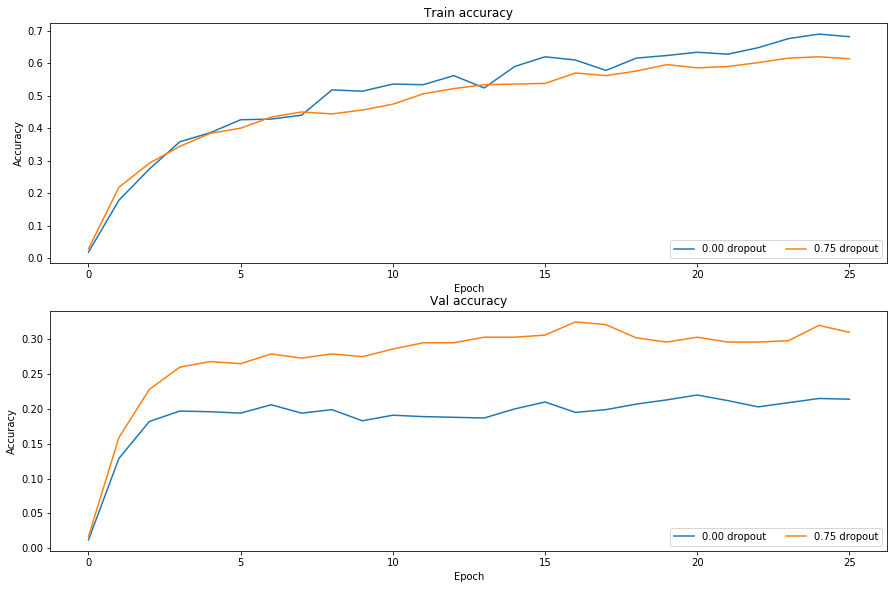

In [39]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, '-', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, '-', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Question
Expliquez la conclusion que l'on peut tirer de ces deux courbes.

## Votre réponse :
Nous pouvons voir que sans dropout, l'entrainement arrive à avoir un petit peu plus de précision que celui avec dropout.Cependant, pendant la phase de test, on peut observer que le réseau entrainé avec dropout est bien plus précis que celui sans dropout.On peut donc conclure que le réseau reconnait mieux ce qu'il ne connait pas si l'on "déforme" les données d'entrainement. On peut dire que le réseau est plus adapté à l'inconnu.